70
[1.         0.98529412 0.97058824 0.95588235 0.94117647 0.92647059
 0.91176471 0.89705882 0.88235294 0.86764706 0.85294118 0.83823529
 0.82352941 0.80882353 0.79411765 0.77941176 0.76470588 0.75
 0.73529412 0.72058824 0.70588235 0.69117647 0.67647059 0.66176471
 0.64705882 0.63235294 0.61764706 0.60294118 0.58823529 0.57352941
 0.55882353 0.54411765 0.52941176 0.51470588 0.5        0.48529412
 0.47058824 0.45588235 0.44117647 0.42647059 0.41176471 0.39705882
 0.38235294 0.36764706 0.35294118 0.33823529 0.32352941 0.30882353
 0.29411765 0.27941176 0.26470588 0.25       0.23529412 0.22058824
 0.20588235 0.19117647 0.17647059 0.16176471 0.14705882 0.13235294
 0.11764706 0.10294118 0.08823529 0.07352941 0.05882353 0.04411765
 0.02941176 0.01470588 0.        ]
Initial value: 2526.975686152469


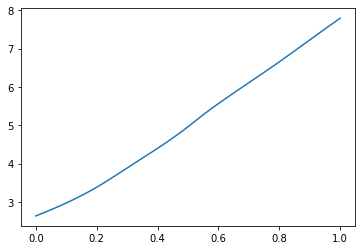

Finite diff:  9168.657043574058
Analytic   :  9168.657044864593


In [33]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import csv
data = np.genfromtxt('./WorldPopulation.csv', delimiter=',', names=True)
    
#data['Year']
data['Population']

T   = data['Year']
Pop = data['Population']/1e9

Ttarget = np.array([2050,2100])


N = np.size(data['Population'])
print(N)

Nb = 1

T = T[:-Nb]
Pop = Pop[:-Nb]
N = np.size(T)

m = T.min()
M = T.max()
T = (T-m)/(M-m);

Ttarget = (Ttarget-m)/(M-m)
print(T)

mult = 1

m1 = 0.1
m2 = 0.9
Tol = 5e-10
Maxiter = 2000

variant = 1

if variant==1:
    x0 = np.array([3,2])
if variant==2:
    x0 = np.array([12,3,3])

# parameters for variant 1: cellphones

def r(x):
    if variant==1:
        return np.array([
           Pop[i]-x[0]*np.exp(x[1]*T[i])  for i in range(0,N)
        ])
    if variant==2:
        return np.array([
           Pop[i]-x[0]/(1+x[1]*np.exp(-x[2]*T[i])) for i in range(0,N)
        ])

def Jac(x):
    if variant==1:
        return np.array([
           np.array([-np.exp(x[1]*T[i]),-x[0]*T[i]*np.exp(x[1]*T[i])])  for i in range(0,N)
        ])
    if variant==2:
        return np.array([
           np.array([-1/(1+x[1]*np.exp(-x[2]*T[i])),\
                     x[0]*np.exp(-x[2]*T[i])/(1+x[1]*np.exp(-x[2]*T[i]))**2,\
                     -x[0]*x[1]*T[i]*np.exp(-x[2]*T[i])/(1+x[1]*np.exp(-x[2]*T[i]))**2\
                    ])  for i in range(0,N)
        ])

    
def J(x):
    res = r(x);
    return sum(res**2)
        
        
def GradJ(x):
    res = r(x)
    Jr  = 2*Jac(x)
    return Jr.T@res
    
    
def GNdir(x):
    res = r(x)
    Jr  = Jac(x)
    Mat = Jr.T@Jr
    try:
        d = -np.linalg.solve(Mat,Jr.T@res)
        return d
    except:
        print("could not invert GN matrix")
        return Jr.T@res


print("Initial value:",J(x0))
plt.figure()
plt.plot(T,Pop)

plt.show()


# gradient test
epst = 1e-6
direction = np.random.random(np.size(x0))

v1 = J(x0+epst*direction)
v2 = J(x0-epst*direction)

g = GradJ(x0)
print("Finite diff: ",(v1-v2)/2/epst)
print("Analytic   : ",np.dot(g,direction))




In [34]:
def GDlinesearch(f,df,x0,tol,maxiter,m1,m2,GN=1):
    phist = []
    vhist = []
    ghist = []
    phist.append(x0)            # Create an array which holds the optimization history
 
    val = f(x0)
    gd   = df(x0)
    vhist.append(val)
    ghist.append(gd)
    iter = 0
    step = 0.1
    prevval = val
    d = gd
    while abs(np.linalg.norm(gd))>=Tol: 
        iter=iter+1
        if(iter>1e3):
            GN=1
        #Line search
        tl=0
        tr=0
        t=1
        step=t
        # choice of the descent direction  
        if GN==1:
            d = GNdir(x0)
        else:
            d = -gd
    

        #np.sqrt(abs((f(x0+step*d,v)-val)))/step<np.sqrt(abs(-(m1*(d*d))))
        while (1==1):
            qt = f(x0+t*d)
            qp = np.dot(gd,d)
            #print(qp)
            #print(tl," ",tr)
            xnext = x0+step*d
            if ((qt-val)/t<=(m1*qp)) and ((qt-val)/t>=(m2*qp)):
                step=t   # we found a good step
                break
            if ((qt-val)/t>(m1*qp)):
                # step too big
                tr = t
            if ((qt-val)/t<(m2*qp)):
                # step too small
                tl = t
            if(tr==0):
                t = 2*tl
            else:
                t = 0.5*(tl+tr)
            if abs(tr-tl)<1e-15*tr or tr<1e-15:
                break
        if(np.linalg.norm(step*d)/np.linalg.norm(x0)<Tol):
            print("Too small change!")
            #d = -gd
            #step = 0.1
            break
        x0 = x0+step*(d)
        val = f(x0)
        gd   = df(x0)
        
        if(iter%10==0):
            print("Iter: ",iter,"| Val: ",val,"| Step: ",step," Grad: ",abs(np.linalg.norm(gd)))
        phist.append(x0)
        vhist.append(val)
        ghist.append(d)
        if(iter>maxiter):
            print('Maximum number of iterations reached!')
            break
        #if(abs(val-prevval)<Tol):
            #print('Function does not decrease enough!')
            #break
        prevval = val
    if(np.linalg.norm(d)<Tol): 
        print('Algorithm converged!')
    print('')
    print('Final output:')
    print("Iter: ",iter,"| Val: ",val,"| Step: ",step," Grad: ",abs(np.linalg.norm(gd)))
    return phist,vhist,ghist

In [35]:
pp,vv,gg = GDlinesearch(J,GradJ,x0,Tol,Maxiter,m1,m2,GN=1)

print('Number of iterations: ',len(pp))
print('Final position: ',pp[-1])



Too small change!

Final output:
Iter:  8 | Val:  1.6998114977340621 | Step:  1  Grad:  1.4861507400406093e-07
Number of iterations:  8
Final position:  [2.84364775 1.05192156]


[2.84364775 1.05192156]


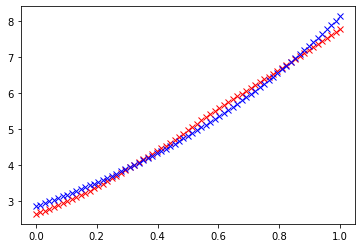

Predictions:  [12.94995406 28.06614295]


In [36]:
plt.figure()
plt.plot(T,Pop,'rx')

xf = pp[-1]

print(xf)
if variant==1:
    zz = np.array([xf[0]*np.exp(xf[1]*(T[i]))  for i in range(0,N)])
    TargetEval = xf[0]*np.exp(xf[1]*(Ttarget))
if variant==2:
    zz = np.array([xf[0]/(1+xf[1]*np.exp(-xf[2]*(T[i])))  for i in range(0,N)])
    TargetEval = xf[0]/(1+xf[1]*np.exp(-xf[2]*(Ttarget)))
    
plt.plot(T,zz,'bx')
plt.show()


print("Predictions: ",TargetEval)

In [19]:
print(np.exp(2000))

inf


/home/beni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
